In [117]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [118]:
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

from src.tower import Tower
from src.embedding import EmbeddingModel
from src.recommender import RecommenderModel
from src.utils.utilities import (
    dataframe_to_Dataset,
    train_test_split,
    plot_history,
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

In [119]:
# Ratings
ratings_df = pd.read_parquet('data/100k-ratings.parquet')
ratings_columns = [
    'bucketized_user_age',
    # 'movie_genres',
    'movie_id',
    'movie_title',
    'raw_user_age',
    'timestamp',
    'user_gender',
    'user_id',
    'user_occupation_label',
    'user_occupation_text',
    'user_rating',
    'user_zip_code',
]
ratings_df['score'] = ratings_df['user_rating']
ratings_dataset = dataframe_to_Dataset(ratings_df, ratings_columns + ['score'])

In [120]:
# Movies
movies_df = pd.read_parquet('data/100k-movies.parquet')
movies_columns = [
    # 'movie_genres',
    'movie_id',
    'movie_title'
]
movies_dataset = dataframe_to_Dataset(movies_df, movies_columns)

### Dataset Splitting

In [121]:
# Train and validation splits
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = 0.8,
    random_state = RANDOM_STATE,
    buffer_size = 10_000
)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 80000
validset_size: 20000


In [122]:
user_embedding_model = EmbeddingModel(
    dataset = ratings_dataset.batch(1_000_000),
    str_features = ['user_id', 'user_zip_code', 'user_occupation_text'],
    int_features = ['user_gender', 'bucketized_user_age'],
    text_features = [],
    timestamp_features = ['timestamp'],
    embedding_dim = 32,
)

movie_embedding_model = EmbeddingModel(
    dataset = movies_dataset.batch(1_000),
    str_features = [],
    int_features = [],
    text_features = ['movie_title'],
    timestamp_features = [],
    embedding_dim = 32,
)

2024-08-29 23:53:40.115781: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [123]:
cross_layer = tfrs.layers.dcn.Cross(
    projection_dim = 16,
    kernel_initializer = "glorot_uniform"
)

In [124]:
candidate_tower = Tower(
    embedding_model = movie_embedding_model,
    cross_layer = cross_layer,
    dense_layers_sizes = [32]
)

query_tower = Tower(
    embedding_model = user_embedding_model,
    cross_layer = cross_layer,
    dense_layers_sizes = [32]
)

In [125]:
factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    # dataset of candidate embeddings from which candidates should be retrieved
    candidates = movies_dataset.batch(128).map(
        candidate_tower
    )
)

In [126]:
# Ranking
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        # tfr.keras.metrics.MeanAveragePrecisionMetric()
    ]
)

# Retrieval
retrieval_task = tfrs.tasks.Retrieval(
    metrics = [
        factorized_top_k_metrics
    ]
)

model = RecommenderModel(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    ranking_task = ranking_task,
    retrieval_task = retrieval_task,
    retrieval_weight = 1.0,
    ranking_weight = 1.0,
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
model.compile(optimizer = optimizer)

In [127]:
# Shuffle the training data for each epoch.
# Batch and cache both the training and evaluation data.
# `cache()` method caches the elements in the dataset in memory. To caches data
# in a file pass the `filename` argument to the method: cache(filename='')
# The first time the dataset is iterated over, its elements will be cached
# either in the specified file or in memory. Subsequent iterations will use the
# cached data.
cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
cached_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'total_val_loss',
    patience = 10,
)

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 2,
    epochs = 100,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/100
79/79 [==============================] - 13s 115ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6705.5712 - regularization_loss: 0.0000e+00 - total_loss: 6705.5712
Epoch 2/100
79/79 [==============================] - 7s 93ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6435.7643 - regularization_loss: 0.0000e+00 - total_loss: 6435.7643 - val_root_mean_squared_error: 1.0733 - val_factor

In [128]:
model.evaluate(cached_ratings_validset, return_dict=True)

20/20 [==============================] - 3s 141ms/step - root_mean_squared_error: 0.9690 - factorized_top_k/top_1_categorical_accuracy: 2.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0021 - factorized_top_k/top_10_categorical_accuracy: 0.0074 - factorized_top_k/top_50_categorical_accuracy: 0.1218 - factorized_top_k/top_100_categorical_accuracy: 0.2824 - loss: 7260.0790 - regularization_loss: 0.0000e+00 - total_loss: 7260.0790


{'root_mean_squared_error': 0.9690064787864685,
 'factorized_top_k/top_1_categorical_accuracy': 0.00019999999494757503,
 'factorized_top_k/top_5_categorical_accuracy': 0.002050000010058284,
 'factorized_top_k/top_10_categorical_accuracy': 0.007400000002235174,
 'factorized_top_k/top_50_categorical_accuracy': 0.121799997985363,
 'factorized_top_k/top_100_categorical_accuracy': 0.2824000120162964,
 'loss': 3661.061279296875,
 'regularization_loss': 0,
 'total_loss': 3661.061279296875}

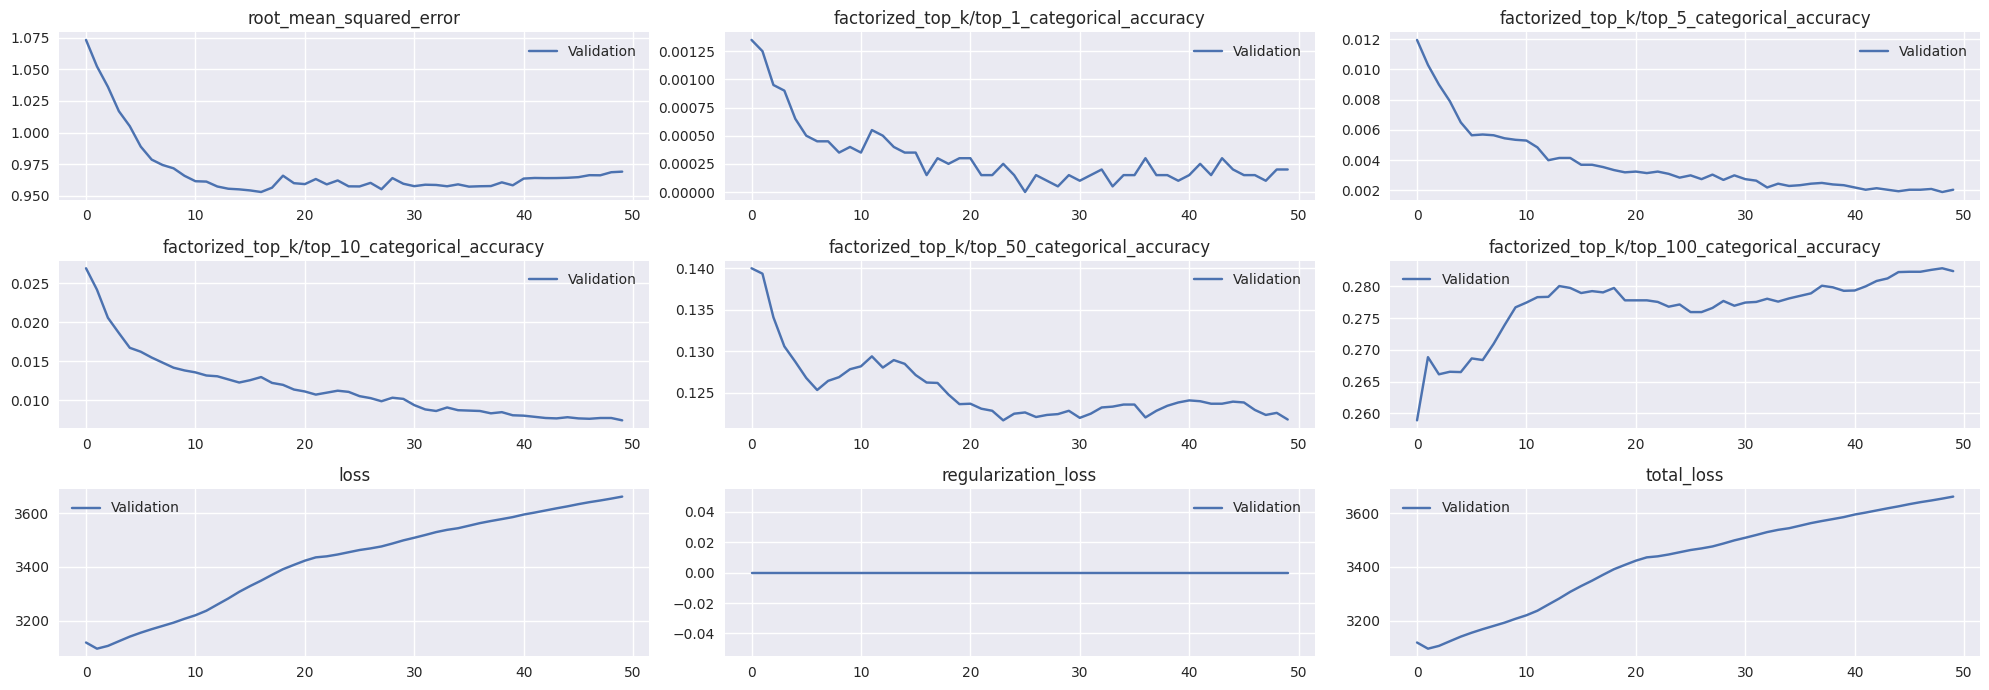

In [129]:
plot_history(history = history, plot_training=False)

In [130]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    model.query_tower,
    k = 10,
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          movies_dataset.batch(100).map(model.candidate_tower)
      )
  )
)

2024-08-30 00:01:21.787904: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1682
2024-08-30 00:01:21.791698: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:89] PartitionerFactory ran in 3.730232ms.


In [131]:
index = 0
data = dict(ratings_df.iloc[index])
data = {k: tf.convert_to_tensor([v]) for k, v in data.items()}

afinity_scores, movie_ids = scann_layer(data)

for movie_id in movie_ids[0]:

    pred = model(data)
    _, _, rating = pred

    print(f"Movie {movie_id}: {rating[0][0]}")

Movie b'494': 4.639195442199707
Movie b'602': 4.639195442199707
Movie b'484': 4.639195442199707
Movie b'478': 4.639195442199707
Movie b'23': 4.639195442199707
Movie b'513': 4.639195442199707
Movie b'645': 4.639195442199707
Movie b'285': 4.639195442199707
Movie b'509': 4.639195442199707
Movie b'490': 4.639195442199707
